In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# To allow interactive plot.
from ipywidgets import *
from IPython.display import display
from datetime import datetime, timedelta
import requests
import json
from time import sleep
import string

#import wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import pipeline, machine learning models, metrics and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix,roc_auc_score,precision_score
from sklearn.metrics.scorer import make_scorer
from imblearn.pipeline import make_pipeline,Pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

#import feature extraction from nltk and sklearn
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import hstack,csr_matrix

from spacy.lemmatizer import Lemmatizer
import en_core_web_sm
from spacy import vocab
import scipy.stats


## Data Problem Statement

   **FAKE NEWS is a problem:**
   In the era of Social Media where news spread is just one click away, fake news spreads quicker and further than ever, creating division and misleading news-readers into wrong conclusions and decisions. 
   Even more insidiously, the fake news problems causes an inability in more canny readers to trust mainstream media: eroding even further at the foundations of democracies.
   
   Unfortunately, the haystack in which fake news hides is massive: everyday, more than 3,200,000 news articles are published online. Against this tide, a small but growing number of fact-checking organisations attempt to combat the misinformation; Reporters Lab has the number at 226.  
   
   Motivation shown, we move on to the meat of this data-science project: creating a fake news detector to assist a hypothetical fact-checking organisation. 
   
   In this project we use a labeled datasets to attempt fake news detection.

**Dataset 1: MisInfoText, Buzzfeed Dataset (2019)**
    Fatemeh Torabi Asr and Maite Taboada (2019) MisInfoText. A collection of news articles, with false and true labels. Dataset.
    
The news for this source was first taken from various Facebook groups by three Buzzfeed reporters, and were labeled with 4 classes:
    
        -Mostly True
        -Mixture of True and False
        -Mostly False
        -No Factual Content
    
The authors of this dataset then followed the URLs in the first dataset, and scraped the full text of each news article from its original source. The resulting dataset includes a total of 1380 news articles on a focused topic (US election and candidates). Veracity labels come in a four-way classification scheme including 1090 mostly true, 170 mixture of true and false, 64 mostly false and 56 articles containing no factual content.

| Type | Count |
| ------------- |:-------------:|
| **Mostly True** | 1090| 
| **Mixture of True and False** |  170 | 
| **Mostly False** |  64| 
| **No Factual Content** |  56 | 
    

### Read CSVs

In [42]:
buzzfeed=pd.read_csv('Cleaned CSV/buzzfeedclean.csv')

In [43]:
buzzfeed.isnull().sum()

id             0
url            0
rating         0
text           0
domain         0
source         0
lower text     0
target         0
nltklemma      0
spacylemma     0
spacylemma2    0
spacy_pos      0
spacy_pos2     0
dtype: int64

In [44]:
df=buzzfeed[['rating', 'text', 'target', 'nltklemma', 'spacylemma2', 'spacylemma',
       'spacy_pos', 'spacy_pos2']]

## Gridsearch for best parameters

As stated in the Data Problem, we want to create a detector for fake news, so our positive class will be fake news.
We will grid search over the following space to discover the best machine learning model.

|Pipeline section|Search Space|Hyper Parameters|  
|--|--|--|  
Preprocessing|NLTK, Spacy, POS, PNscrub|-|  
|Oversampler|SMOTE, Simple Oversampling|-|
|Vectorizer|CVEC, TFIDF|ngrams,max_features|
|Classifier|Logistic Regression,Naive Bayes,Random Forests|C,-,max_depth,max_features|


### Pipeline function to iterate over different lemmatizers, vectorizers, classifiers and parameters, and save the results to a csv. Optimizing to f1 score

In [5]:
def SupraPipeline(Lemmatizer,Vectorizerlist,ClassifierList,Dfnames,pipe_params,methodgridname,scorer):
    Methodgrid=[]
    metnum=len(Lemmatizer)*len(Vectorizerlist)*len(Classifierlist)
    n=0
    for index,column in enumerate(Lemmatizer):
        X=df[column]
        y=df['target']
        X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)
        

        for Vectorizer in Vectorizerlist:
            for Classifier in ClassifierList:
                n+=1
                print(f'{n} of {metnum} of methods attempting')
                method={}
                pipe = Pipeline([
                    ('vec', Vectorizer ),
                    ('smote', SMOTE(random_state=77)),
                    ('class', Classifier)
                ])

                gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=-1,scoring=scorer)
                gs.fit(X_train, y_train)
                predictions=gs.predict(X_test)
                pred_prob=gs.predict_proba(X_test)[:,1]
                
                
                
                
                method=(gs.best_params_)
                method['Vectorizer']=str(Vectorizer).split('(')[0]
                method['Lemmatizer']=str(Dfnames[index])
                method['Classifier']=str(Classifier).split('(')[0]
               
                method['ROC-AUC score']=round(roc_auc_score(y_test, pred_prob),3)
                
                method['Cross_Val_Score']=(gs.best_score_)
                method['accuracy']=accuracy_score(predictions,y_test)
                method['f1']=f1_score(predictions,y_test)
                method['precision']=precision_score(predictions,y_test)
                method['recall']=recall_score(predictions,y_test)
                Methodgrid.append(method)
                
    Methodgrid=pd.DataFrame(Methodgrid)
    Methodgrid.to_csv('GridSearch Output/'+methodgridname,index=False)
    return Methodgrid

### Assessment Functions

In [13]:
## Prints a Confusion Matrix with columns and indexes labeled correctly
def printcm(pred_df):
    
    predictions=pred_df['predict']
    ground_truth=pred_df['true_values']
    columns=['Real','Fake']
    predictions=pd.DataFrame(predictions)


    
    cm=pd.DataFrame(confusion_matrix(ground_truth,predictions),columns=[('Predicted '+str(x)) for x in columns])
    cm['index']=cm['index']=[('Real '+str(x)) for x in columns]
    cm.set_index('index',inplace=True)
    display(cm)

In [14]:
#prints out the various metrics, confusion matrix, and returns the prediction dataframe for later visualization
def assess_model(model,X_test,y,threshold):   

    y_test=y
    
    pred_prob=model.predict_proba(X_test)[:,1]
    pred_df=pd.DataFrame(pred_prob,columns=['pred_probs'])
    pred_df['titles']=X_test.values
    pred_df['true_values']=y_test.values
    pred_df['predict']=pred_df['pred_probs']>threshold
    pred_df['predict']=pred_df['predict'].astype(int)
    predictions=pred_df['predict'].values
    method={}
    
    method['accuracy']=accuracy_score(y_test,predictions)
    method['f']=f1_score(y_test,predictions)
    method['precision']=precision_score(y_test,predictions)
    method['recall']=recall_score(y_test,predictions)
    method['fprate']=FPR(pred_df,'true_values','pred_probs',threshold)
    method['tprate']=TPR(pred_df,'true_values','pred_probs',threshold)
    method['tprate/fprate']=method['tprate']/method['fprate']
    
    printcm(pred_df)
    
    print(method)
    return pred_df

In [15]:
## returns precision and recall at a particular threshold
def custom_pr(true_col,pred_prob_col,threshold,beta=1):
    fbeta=0
    df=pd.DataFrame()
    df['true_col']=true_col
    df['pred_prob_col']=pred_prob_col

    TN = df[(df['true_col'] == 0) & (df['pred_prob_col'] <= threshold)].shape[0]
    FP = df[(df['true_col'] == 0) & (df['pred_prob_col'] > threshold)].shape[0]
    TP = df[(df['true_col'] == 1) & (df['pred_prob_col'] >= threshold)].shape[0]
    FN = df[(df['true_col'] == 1) & (df['pred_prob_col'] < threshold)].shape[0]
    #print(TN,FP,TP,FN)
    
    
    if TP==0:
        precision=0
        recall=0
    else:
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        
    if (precision==0 or recall==0):
        fbeta=0
    else:
        fbeta=(1+beta**2) * (precision * recall) / ((beta**2)*precision + recall)
    return [precision,recall]

In [16]:
#sets recall to a certain threshold, then checks precision of that point.
def set_recall(ground_truth, pred_proba,recall_threshold=0.95):
    error,max_error=0,0
    thresholds=np.linspace(1,0,2001)
    
    for prob in thresholds:
        if custom_pr(ground_truth,pred_proba, prob)[1]>recall_threshold:#if the recall is above the set point, return precision
            print(f'probability threshold is{prob}')
            return custom_pr(ground_truth,pred_proba, prob)

setrecallscore=make_scorer(set_recall,greater_is_better=True,needs_proba=True)

In [17]:
# plots a probability distribution of the predictions
def plotprob(pred_df):
# Create figure.
  plt.figure(figsize = (10,7))

# Create two histograms of observations.
  plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
          bins=25,
          color='b',
          alpha = 0.6,
          label='Outcome = 0')
  plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
          bins=25,
          color='orange',
          alpha = 0.6,
          label='Outcome = 1')

# Label axes.
  plt.title('Distribution of P(Outcome = 1)', fontsize=22)
  plt.ylabel('Frequency', fontsize=18)
  plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
  plt.legend(fontsize=20);
  pass

In [18]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

#define function to calculate f1 score for a particular threshold
def f1(df,true_col,pred_prob_col,threshold):
    TN = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    FP = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    TP = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    FN = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    if TP==0:
        precision=0
    else:
        precision=TP/(TP+FP)
        
    recall=TP/(TP+FN)
    if (precision==0 or recall==0):
        f1=0
    else:
        f1=2 * (precision * recall) / (precision + recall)
    return f1

In [19]:
#finds the f1 max, and the threshold for a set of prediction probabilities
def f1max(valid_pred_df):
  thresholds=np.linspace(0,1,200)
  f1pr_values = [f1(valid_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
  #print('f1 max:',np.max(f1pr_values))
  optimal_threshold=thresholds[f1pr_values.index(np.max(f1pr_values))]
  #print('At threshold:',optimal_threshold)
  return optimal_threshold

In [20]:
#plots the receiver operating curve
def rocauccurve(pred_df):
  # Create figure.
  plt.figure(figsize = (10,7))
  # Create threshold values. (Dashed red line in image.)
  thresholds = np.linspace(0, 1, 200)
  # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
  tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
  fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

  # Plot ROC curve.
  plt.plot(fpr_values, # False Positive Rate on X-axis
          tpr_values,
          label='ROC Curve')
  # Plot ROC curve.
  plt.plot(thresholds, # False Positive Rate on X-axis
          thresholds,
          label='ROC Curve')
  # Label axes.
  plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
  plt.ylabel('Sensitivity', fontsize=18)
  plt.xlabel('1 - Specificity', fontsize=18)

  # Create legend.
  plt.legend(fontsize=16);

### Logistic Regression

In [14]:
stopwords=['trump','hillary','bush','donald','clinton']
Vectorizerlist=[TfidfVectorizer(stop_words=stopwords),CountVectorizer(stop_words=stopwords)]
Lemmatizer=['nltklemma','spacylemma','spacylemma2']
Dfnames=['nltk','spacy','spacy2']
Classifierlist=[LogisticRegression()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(10000,50000,5)],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.90],
                    'vec__ngram_range': [(1,1),(1,2),(1,3)],
                    'vec__stop_words':[None],
    
                }

logreg=SupraPipeline(Lemmatizer,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'logreg.csv','f1')

1 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


6 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
logreg=pd.read_csv('GridSearch Output/logreg.csv')

In [16]:
logreg.sort_values('Cross_Val_Score',ascending=False)

,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,Vectorizer,Lemmatizer,Classifier,ROC-AUC score,Cross_Val_Score,accuracy,f1,precision,recall
0,0.95,10000,3,"(1, 3)",NaN,TfidfVectorizer,nltk,LogisticRegression,0.843,0.534456,0.788406,0.496552,0.493151,0.500000
2,0.95,10000,3,"(1, 1)",NaN,TfidfVectorizer,spacy,LogisticRegression,0.839,0.530216,0.811594,0.557823,0.561644,0.554054
4,0.95,10000,3,"(1, 2)",NaN,TfidfVectorizer,spacy2,LogisticRegression,0.844,0.512243,0.811594,0.551724,0.547945,0.555556
1,0.95,50000,2,"(1, 3)",NaN,CountVectorizer,nltk,LogisticRegression,0.817,0.468276,0.794203,0.517007,0.520548,0.513514
3,0.95,10000,2,"(1, 3)",NaN,CountVectorizer,spacy,LogisticRegression,0.816,0.451664,0.802899,0.507246,0.479452,0.538462
5,0.95,30000,2,"(1, 3)",NaN,CountVectorizer,spacy2,LogisticRegression,0.786,0.434912,0.788406,0.451128,0.410959,0.500000


### Naive Bayes

In [17]:
stopwords=['trump','hillary','bush','donald','clinton']
Vectorizerlist=[TfidfVectorizer(stop_words=stopwords),CountVectorizer(stop_words=stopwords)]
Lemmatizer=['nltklemma','spacylemma','spacylemma2']
Dfnames=['nltk','spacy','spacy2']
Classifierlist=[MultinomialNB()]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(10000,50000,5)],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.90],
                    'vec__ngram_range': [(1,1),(1,2),(1,3)],
                    'vec__stop_words':[None],
    
                }

NBsearch=SupraPipeline(Lemmatizer,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'NB.csv','f1')

1 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


2 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


3 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


4 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


5 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


6 of 6 of methods attempting
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


In [18]:
NBsearch=pd.read_csv('GridSearch Output/NB.csv')

In [19]:
NBsearch.sort_values('Cross_Val_Score',ascending=False)

,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,Vectorizer,Lemmatizer,Classifier,ROC-AUC score,Cross_Val_Score,accuracy,f1,precision,recall
0,0.95,20000,2,"(1, 1)",NaN,TfidfVectorizer,nltk,MultinomialNB,0.825,0.563040,0.776812,0.574586,0.712329,0.481481
2,0.95,30000,2,"(1, 2)",NaN,TfidfVectorizer,spacy,MultinomialNB,0.821,0.538497,0.768116,0.578947,0.753425,0.470085
4,0.95,10000,2,"(1, 2)",NaN,TfidfVectorizer,spacy2,MultinomialNB,0.822,0.535877,0.747826,0.539683,0.698630,0.439655
3,0.95,10000,3,"(1, 2)",NaN,CountVectorizer,spacy,MultinomialNB,0.776,0.480043,0.768116,0.466667,0.479452,0.454545
1,0.95,10000,3,"(1, 1)",NaN,CountVectorizer,nltk,MultinomialNB,0.771,0.470349,0.771014,0.439716,0.424658,0.455882
5,0.95,10000,3,"(1, 2)",NaN,CountVectorizer,spacy2,MultinomialNB,0.775,0.440966,0.785507,0.478873,0.465753,0.492754


### Random Forests Classifier

In [20]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
stopwords=['trump','hillary','bush','donald','clinton']
Vectorizerlist=[TfidfVectorizer(stop_words=stopwords),CountVectorizer(stop_words=stopwords)]
Lemmatizer=['nltklemma','spacylemma','spacylemma2']
Dfnames=['nltk','spacy','spacy2']
Classifierlist=[RandomForestClassifier(n_estimators=100)]
pipe_params = {
                    'vec__max_features': [int(i) for i in np.linspace(10000,50000,5)],
                    'vec__min_df': [2,3],
                    'vec__max_df': [.95,.90],
                    'vec__ngram_range': [(1,1),(1,2),(1,3)],
                    'vec__stop_words':[None],
                    'class__max_depth':[3,5,10],
                    'class__max_features':[3,5,10,20]
    
                }

#RFsearch=SupraPipeline(Lemmatizer,Vectorizerlist,Classifierlist,Dfnames,pipe_params,'RF.csv','f1')

In [22]:
RFsearch=pd.read_csv('GridSearch Output/RF.csv')

In [23]:
RFsearch.sort_values('Cross_Val_Score',ascending=False)

,vec__max_df,vec__max_features,vec__min_df,vec__ngram_range,vec__stop_words,Vectorizer,Lemmatizer,Classifier,ROC-AUC score,Cross_Val_Score,accuracy,f1,precision,recall
1,0.95,20000,2,"(1, 3)",NaN,CountVectorizer,nltk,RandomForestClassifier,0.803,0.293446,0.785507,0.478873,0.465753,0.492754
2,0.95,50000,3,"(1, 3)",NaN,TfidfVectorizer,spacy,RandomForestClassifier,0.802,0.282180,0.817391,0.546763,0.520548,0.575758
0,0.95,20000,3,"(1, 3)",NaN,TfidfVectorizer,nltk,RandomForestClassifier,0.821,0.275703,0.820290,0.523077,0.465753,0.596491
3,0.95,40000,2,"(1, 3)",NaN,CountVectorizer,spacy,RandomForestClassifier,0.802,0.273933,0.800000,0.510638,0.493151,0.529412


## Best model

The best model found is shown in the table below:  



|Classifier|Lemmatization|Encoding|max_df|max_features|min_df|ngram_range|  
|:----|----|----|----|----|----|:----:|  
|Logistic Regressor|spacylemma2|Tfidf|0.95|10000|2|(1,1)|  

### Train Model

In [45]:
df['spacylemma2']

0         day ago , PROPN despicable spawn tweet meme ...
1         group intelligence official national securit...
2         new investigation determine PROPN charitable...
3         new video emerge moment police officer gun P...
4         ninety - - year - old PROPN PROPN PROPN vete...
                              ...                        
1375    choose explanation happen PROPN PROPN recent w...
1376    You?d think put list 8 bad mass murderer ameri...
1377    PROPN standard bearer political party champion...
1378    PROPN get love PROPN PROPN . PROPN PROPN futur...
1379    PROPN probably see bumper sticker , ? Don?t li...
Name: spacylemma2, Length: 1380, dtype: object

In [46]:
X=df['spacylemma2']
y=df['target']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)

In [47]:

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23,test_size=0.2)

lr=LogisticRegression(C=1)
tvec=TfidfVectorizer(max_df=0.95,min_df=2,ngram_range=(1,2),max_features=10000)
smote=SMOTE(random_state=77)

pipe=make_pipeline(tvec,smote,lr)
pipe.fit(X_train,y_train)


/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95,
                                 max_features=10000, min_df=2,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 tok...
                       out_step='deprecated', random_state=77, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
    

In [49]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(pipe, filename)

['finalized_model.sav']

### Assess Model

#### Confusion Matrix

In [21]:
#Print the Confusion Matrix and create the prediction dataframe required for other assessment functions
pred_df=assess_model(pipe,X_test,y_test,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,189,29
Real Fake,20,38


{'accuracy': 0.822463768115942, 'f': 0.608, 'precision': 0.5671641791044776, 'recall': 0.6551724137931034, 'fprate': 0.1330275229357798, 'tprate': 0.6551724137931034, 'tprate/fprate': 4.9250891795481575}


#### Probability Distribution

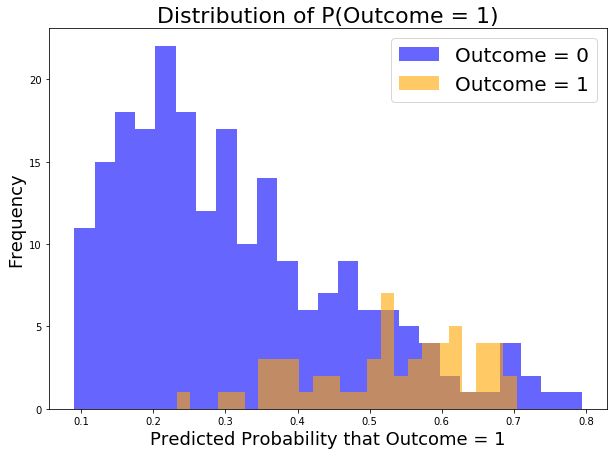

In [22]:
plotprob(pred_df)

#### Receiver Operating Curve

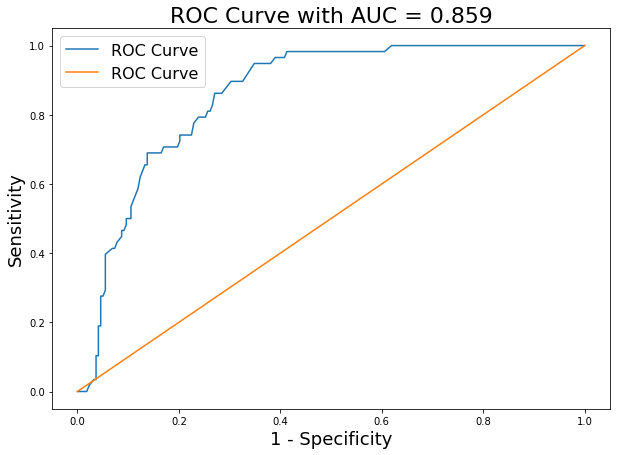

In [23]:
rocauccurve(pred_df)

### Misclassification Analysis

Here, the misclassifications are analysed, based on the original threshold

In [24]:
pred_df=assess_model(pipe,X_test,y_test,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,189,29
Real Fake,20,38


{'accuracy': 0.822463768115942, 'f': 0.608, 'precision': 0.5671641791044776, 'recall': 0.6551724137931034, 'fprate': 0.1330275229357798, 'tprate': 0.6551724137931034, 'tprate/fprate': 4.9250891795481575}


In [25]:
misclass=pd.DataFrame(pred_df[pred_df['true_values']!=pred_df['predict']])

In [26]:
misclass

,pred_probs,titles,true_values,predict
2,0.374233,PROPN PROPN PROPN PROPN PROPN convert PROPN PR...,1,0
9,0.670234,key skill public speaker ability handle hostil...,0,1
25,0.382100,". okay , liberal say year . PROPN PROPN ( incr...",1,0
31,0.737858,"pro - gun crowd love gun , respect . , case tr...",0,1
34,0.690900,call ? small government ? PROPN run state PR...,0,1
36,0.607398,season premiere hit television drama PROPN fea...,0,1
37,0.397891,PROPN PROPN PROPN PROPN call PROPN PROPN weeke...,1,0
48,0.423860,"PROPN probably see bumper sticker , ? Don?t li...",1,0
53,0.369392,PROPN rerun age include probably major politic...,1,0
58,0.704404,protest shake city PROPN night injure sixtee...,0,1


In [27]:
fp=misclass[misclass['true_values']==1]['titles']
fn=misclass[misclass['true_values']==0]['titles']


In [28]:
corclass=pd.DataFrame(pred_df[pred_df['true_values']==pred_df['predict']])

In [29]:
tp=corclass[corclass['true_values']==1]['titles']
tn=corclass[corclass['true_values']==0]['titles']


In [30]:
FPcloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(fp.sum())
FNcloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(fn.sum())
TPcloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(tp.sum())
TNcloud=WordCloud(width=1080,height=720,background_color='white',stopwords=STOPWORDS,max_words=30,prefer_horizontal=True,regexp='(?u)\\b\\w\\w+\\b').generate(tn.sum())

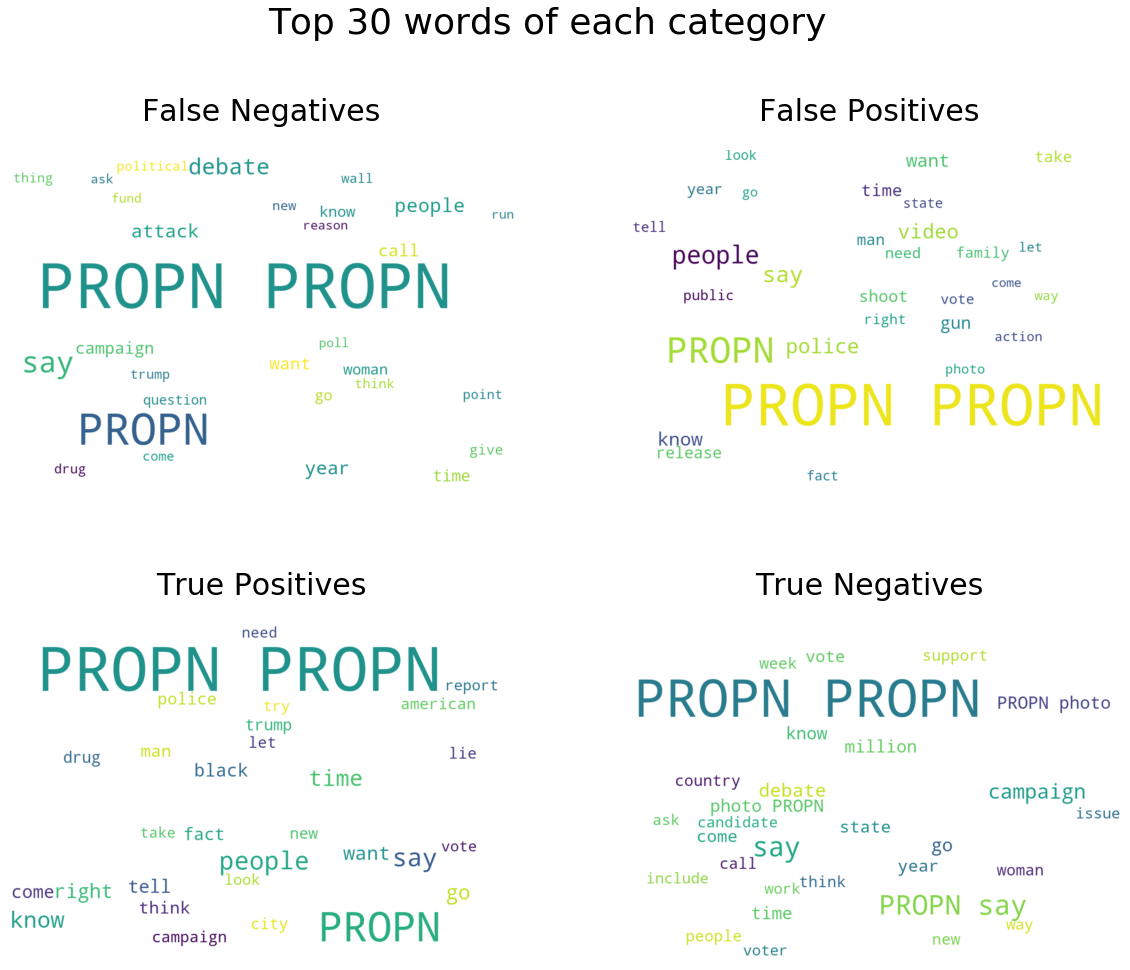

In [31]:

ncols=2
nrows=2
fig,ax=plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*10,8*nrows))
ax=ax.ravel()
cloudlist=[FPcloud,FNcloud,TPcloud,TNcloud]
cloudtitles=['False Negatives','False Positives','True Positives','True Negatives']
for n,axes in enumerate(ax):
    axes.axis("off")
    axes.imshow(cloudlist[n], interpolation='bilinear')
    axes.set_title(str(cloudtitles[n]),fontsize=30,pad=30)

fig.suptitle('Top 30 words of each category',fontsize=36,)

plt.show()

**As we can see, the wordclouds for both types of misclassifications are very similiar**

In [32]:
topwords=pd.DataFrame()
for n,x in enumerate(cloudlist):
    
    topwords[cloudtitles[n]]=list(x.words_)[:10]
    topwords[cloudtitles[n]+'_freq']=list(x.words_.values())[:10]

#### Top 10 ngrams of each group

****

In [33]:
topwords

,False Negatives,False Negatives_freq,False Positives,False Positives_freq,True Positives,True Positives_freq,True Negatives,True Negatives_freq
0,PROPN PROPN,1.000,PROPN PROPN,1.000000,PROPN PROPN,1.000000,PROPN PROPN,1.000000
1,PROPN,0.400,PROPN,0.237762,PROPN,0.344221,PROPN say,0.049789
2,say,0.130,people,0.087413,people,0.071608,say,0.047579
3,debate,0.072,say,0.073427,say,0.070352,campaign,0.026000
4,people,0.052,police,0.061189,time,0.056533,debate,0.021789
5,year,0.050,video,0.057692,know,0.056533,go,0.021158
6,attack,0.050,know,0.050699,go,0.047739,know,0.019053
7,want,0.040,want,0.048951,right,0.042714,time,0.018737
8,call,0.040,gun,0.043706,want,0.041457,photo PROPN,0.018632
9,campaign,0.038,time,0.041958,tell,0.037688,million,0.018211


### Coefficient Analysis

In [34]:
coef=pipe.steps[2][1].coef_[0]

In [35]:
features=pipe.steps[0][1].get_feature_names()

In [36]:
Featdf=pd.DataFrame(zip(features,coef),columns=['Feature','Coefficient'])
Featdf['Odds Story Fake']=Featdf['Coefficient'].apply(lambda x: np.exp(x))
Featdf['Odds Story True']=Featdf['Coefficient'].apply(lambda x: 1/np.exp(x))

In [39]:
Featdf[['Feature','Odds Story True']].sort_values('Odds Story True',ascending=False)[:10]

,Feature,Odds Story True
8012,say,23.951448
7068,propn say,10.209718
8697,story,6.433719
8075,say propn,4.693919
8698,story continue,3.820493
8699,story highlight,3.803722
1257,campaign,3.705802
9959,year,3.427337
3669,highlight,2.968600
160,2015,2.960766


One thing that stands out to me is the occurrence of the word "say"/"propn say", that appears to be quite an important indicator of whether a story is true. This could be a sign of more objective reporting.

Other parts, such as "story highlight" and "story continue" may be characteristics of a particular news network that escaped scrubbing.

In [40]:
Featdf[['Feature','Odds Story Fake']].sort_values('Odds Story Fake',ascending=False)[:10]

,Feature,Odds Story Fake
1586,com,4.949081
3495,gun,4.668997
9046,terrorist,4.298837
9669,vote,3.534047
4412,let,3.532923
9676,vote propn,3.464942
4734,matter,3.241747
2846,explosion,3.190259
4444,lie,2.957303
1991,criminal,2.801439


Words that greatly increase the odds of it being a fake news story includes many hotly debated topics:  

*gun,  -> gun-control  
terrorist,  -> terrorism  
vote,  -> elections  
lie,  -> ironic, but yes accusing someone of lying has a high chance of being fake news  
american,  -> interesting, does this coincide with patriotism?  
vote propn(proper noun) -> again elections 
criminal -> crime*  

This could be a good indicator as to where to look for fake news stories: **hotly debated and controversial topics**.

## Parts of Speech Model
**Just as an interest thing, I wanted to see if I could differentiate**

### Train Model

In [45]:
df['spacy_pos2']

0       SPACE DET ADJ NOUN ADV PROPN ADJ NOUN VERB ADP...
1       SPACE DET NOUN ADP ADP NUM ADJ NOUN NOUN CCONJ...
2       SPACE DET ADJ NOUN AUX VERB SCONJ PROPN ADJ NO...
3       SPACE DET ADJ NOUN AUX VERB ADP DET NOUN ADV C...
4       SPACE DET NUM NUM NOUN ADJ PROPN PROPN PROPN N...
                              ...                        
1375    PRON AUX VERB NUM CCONJ ADJ ADP DET NOUN ADP P...
1376    PUNCT VERB SCONJ VERB ADP DET NOUN ADP DET NUM...
1377    PROPN DET ADJ NOUN ADP DET ADJ NOUN PRON AUX V...
1378    PROPN VERB PART VERB PROPN PROPN DET ADJ PROPN...
1379    PROPN ADV VERB DET NOUN NOUN PRON VERB VERB IN...
Name: spacy_pos2, Length: 1380, dtype: object

In [67]:
X=df['spacy_pos2']
y=df['target']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23,test_size=0.2)

In [68]:

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=23)

lr=LogisticRegression(C=1)
tvec=TfidfVectorizer(max_df=0.95,min_df=2,ngram_range=(1,3),max_features=50000)
smote=SMOTE(random_state=77)

pipepos=make_pipeline(tvec,smote,lr)
pipepos.fit(X_train,y_train)


/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95,
                                 max_features=50000, min_df=2,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 tok...
                       out_step='deprecated', random_state=77, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
    

### Assess Model

In [69]:

pred_df=assess_model(pipepos,X_test,y_test,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,208,64
Real Fake,35,38


{'accuracy': 0.7130434782608696, 'f': 0.43428571428571433, 'precision': 0.37254901960784315, 'recall': 0.5205479452054794, 'fprate': 0.23529411764705888, 'tprate': 0.5205479452054794, 'tprate/fprate': 2.212328767123287}


In [70]:
pred_df

,pred_probs,titles,true_values,predict
0,0.434875,NUM NOUN AUX VERB CCONJ ADJ NOUN AUX VERB ADP ...,0,0
1,0.357212,DET NOUN PRON VERB ADP DET ADJ NOUN ADP NOUN N...,0,0
2,0.180183,ADP DET PROPN PROPN NOUN ADJ PROPN PROPN NUM P...,0,0
3,0.381576,NOUN NOUN PROPN AUX VERB ADP DET NOUN ADP ADV ...,0,0
4,0.146194,DET ADP NOUN ADJ ADP NOUN NOUN NOUN AUX VERB A...,0,0
...,...,...,...,...
340,0.235631,ADP DET PROPN NUM NUM NOUN NOUN PROPN PROPN IN...,0,0
341,0.587792,PROPN NOUN AUX VERB ADP ADP PRON NUM ADP NUM C...,0,1
342,0.333818,PROPN PROPN VERB PRON AUX PART VERB ADV DET NO...,0,0
343,0.557130,NOUN ADP NOUN PROPN PART NOUN NOUN DET PROPN P...,0,1


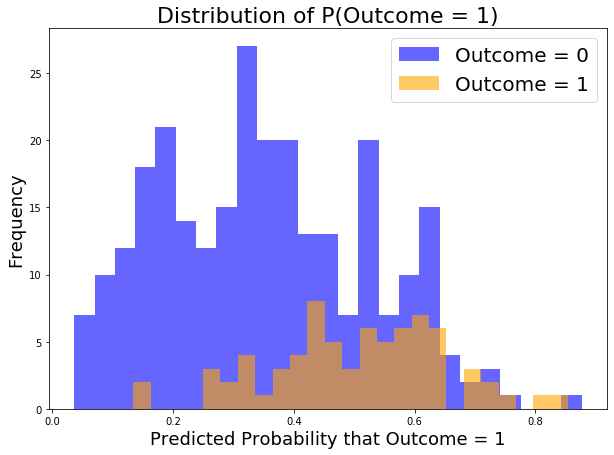

In [71]:
plotprob(pred_df)

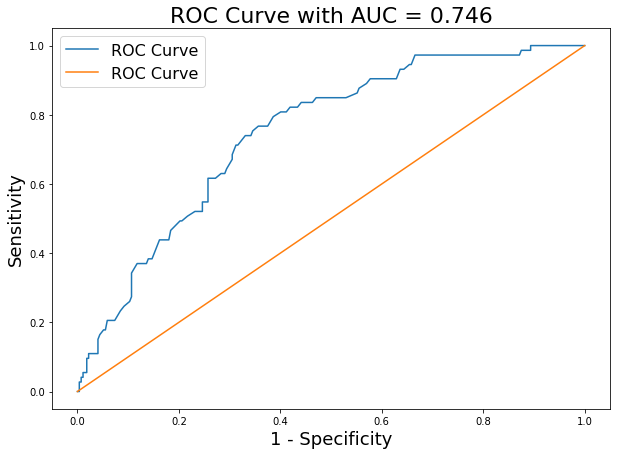

In [72]:
rocauccurve(pred_df)

### Coefficient Analysis

In [101]:
coef=pipepos.steps[2][1].coef_[0]

In [53]:
features=pipepos.steps[0][1].get_feature_names()

In [55]:
Featdf=pd.DataFrame(zip(features,coef),columns=['Feature','Coefficient'])

In [56]:
Featdf['odds contains fake']=Featdf['Coefficient'].apply(lambda x: np.exp(x))

In [57]:
Featdf['odds true']=Featdf['Coefficient'].apply(lambda x: 1/np.exp(x))

In [58]:
Featdf.sort_values('odds true',ascending=False)[:10]

,Feature,Coefficient,odds contains fake,odds true
141,part noun,-3.630465,0.026504,37.730346
229,verb propn,-3.137517,0.043390,23.046581
172,propn part,-2.401571,0.090576,11.040511
144,part pron,-1.487261,0.225991,4.424960
227,verb num,-1.479584,0.227732,4.391118
35,adv noun,-1.441468,0.236580,4.226897
124,num noun,-1.328298,0.264928,3.774614
70,cconj pron,-1.156944,0.314446,3.180199
98,intj intj,-1.061842,0.345818,2.891692
113,noun sconj,-0.999611,0.368023,2.717225


In [59]:
Featdf.sort_values('odds contains fake',ascending=False)[:10]

,Feature,Coefficient,odds contains fake,odds true
107,noun adv,2.711903,15.057909,0.066410
120,num aux,2.399033,11.012517,0.090806
33,adv det,2.351786,10.504319,0.095199
31,adv aux,2.085869,8.051587,0.124199
38,adv pron,1.998794,7.380149,0.135499
231,verb sconj,1.977125,7.221947,0.138467
75,cconj verb,1.953086,7.050415,0.141836
165,propn adv,1.942554,6.976548,0.143337
55,aux pron,1.797607,6.035190,0.165695
8,adj part,1.787056,5.971848,0.167452


## Case Study 1: Thresholding  

**Identifying where to set the threshold to optimize for different use cases and populations**

We assume a hypothetical news dataset on which our predictions have the same probability distribution, consisting of 10,000 real news and 100 pieces of fake news being produced daily. As a starting news agency, we only have the capability of checking 100 pieces of news manually each day, and we want to maximize the number of fake news being caught.

This means that we want to maximize the average number of True Positives in the news that is checked.

We will compare three methods:

1. Random Sampling without a data science model
2. Using the original threshold of the model
3. Using a modified threshold to maximize True Positives caught.


### Function Definition

In [24]:
### Defining function to create populations of fake and real news
from random import shuffle
def pop(numfake,numtrue):
    pop=[1 for x in range(numfake)]
    pop.extend([0 for y in range(numtrue)])
    shuffle(pop)
    return pop

In [25]:
### Fnction to check a random sample of a created population
def check(pop,n=100):
    n=np.random.choice(pop,n)
    return n

In [26]:
#given a assumed population distribution, and a maximum capacity of checking, what is the optimal threshold?
def maximizeTP(pred_df,fakes=100,reals=10000,max_check=100):
    error,max_error=0,0
    thresholds=np.linspace(1,0,201)
    TPs=[]
    for prob in thresholds:
        FPrate=FPR(pred_df,'true_values','pred_probs',prob)
        TPrate=TPR(pred_df,'true_values','pred_probs',prob)
        if TPrate*fakes+FPrate*reals>max_check:    
            try: TPs.append(max_check*TPrate*fakes/(TPrate*fakes+reals*FPrate))
            except: TPs.append(0)
        else:
            TPs.append(TPrate*fakes)
    TPmax=np.max(TPs)
    prob=thresholds[TPs.index(TPmax)]
        
    return [prob,TPmax]

### Example thresholding

Given an original population of 10,000 real news with 100 fake news, we find the increase in fake news detected by random sampling, our model, and our model with a modified threshold

#### Random Sampling

In [79]:
#Over 100,000 draws, 100 draws averages out to 1 fake news being the in the sample
samp=pop(100,10000)
TPfound=np.mean([np.sum(check(samp)) for x in range(10000)])

In [80]:
print(f'The average number of fake news articles found using the random sampling after 10000 draws is {TPfound}')

The average number of fake news articles found using the random sampling after 10000 draws is 0.9944


#### Using the Original Threshold of the model

In [114]:
pred_df=assess_model(pipe,X_test,y_test,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,189,29
Real Fake,20,38


{'accuracy': 0.822463768115942, 'f': 0.608, 'precision': 0.5671641791044776, 'recall': 0.6551724137931034, 'fprate': 0.1330275229357798, 'tprate': 0.6551724137931034, 'tprate/fprate': 4.9250891795481575}


In [82]:
TP=int(TPR(pred_df,'true_values','pred_probs',0.5)*100)
FP=int(FPR(pred_df,'true_values','pred_probs',0.5)*10000)

Applying this model to the population, we would get on average:  
    False Positives: fprate * 10000  
    True Positives: tprate * 100  
    

In [83]:
print(TP)
print(FP)

65
1330


In [84]:
samp=pop(TP,FP)

In [85]:
TPfound=np.mean([np.sum(check(samp)) for x in range(10000)])
print(f'The average number of fake news articles found using the model without thresholding after 10000 draws is {TPfound}')

The average number of fake news articles found using the model without thresholding after 10000 draws is 4.6567


#### Modified Threshold

In [120]:
# Set the threshold based on the train_pred_df to avoid data leakage
train_pred_df=assess_model(pipe,X_train,y_train,TPthresh)
TPthresh=f1max(train_pred_df)
print(TPthresh)

,Predicted Real,Predicted Fake
index,,
Real Real,849,23
Real Fake,23,209


{'accuracy': 0.9583333333333334, 'f': 0.9008620689655172, 'precision': 0.9008620689655172, 'recall': 0.9008620689655172, 'fprate': 0.026376146788990806, 'tprate': 0.9008620689655172, 'tprate/fprate': 34.15442278860572}
0.5628140703517588


In [97]:
pred_df=assess_model(pipe,X_test,y_test,TPthresh)

,Predicted Real,Predicted Fake
index,,
Real Real,201,17
Real Fake,33,25


{'accuracy': 0.8188405797101449, 'f': 0.5, 'precision': 0.5952380952380952, 'recall': 0.43103448275862066, 'fprate': 0.07798165137614677, 'tprate': 0.43103448275862066, 'tprate/fprate': 5.527383367139961}


In [99]:
TP=int(TPR(pred_df,'true_values','pred_probs',TPthresh)*100)
FP=int(FPR(pred_df,'true_values','pred_probs',TPthresh)*10000)

In [100]:
print(TP)
print(FP)

43
779


In [101]:
samp=pop(TP,FP)

In [102]:
TPfound=np.mean([np.sum(check(samp)) for x in range(10000)])
print(f'The average number of fake news articles found using thresholding on the model after 10000 draws is {TPfound}')

The average number of fake news articles found using thresholding on the model after 10000 draws is 5.2188


### Thresholding for different prior populations and No. of Checks

To study the relationship between the prior population, quantity of news checked and optimal decision boundary, we write the following function

**Search Space**

In [108]:
priors=[10,100,1000,5000]
maxchecks=[10,100,1000,5000]

**Loop through each prior and no. of checks and do a random sample, normal threshold, and modified threshold**

In [115]:
randomsample=[]
normthresh=[]
modthresh=[]
checks=[]
fakes=[]
for maxcheck in maxchecks:    
    for prior in priors:
        
        rsamp=pop(prior,10000)
        RS=np.mean([np.sum(check(rsamp,n=maxcheck)) for x in range(10000)])
        randomsample.append(RS)

        TP=int(TPR(pred_df,'true_values','pred_probs',0.5)*prior)
        FP=int(FPR(pred_df,'true_values','pred_probs',0.5)*10000)
        nsamp=pop(TP,FP)
        maxcheckN=maxcheck
        if maxcheckN>(TP+FP):
            maxcheckN=(TP+FP)
        NT=np.mean([np.sum(check(nsamp,n=maxcheckN)) for x in range(10000)])
        normthresh.append(NT)

        TPthresh=f1max(train_pred_df)
        TP=int(TPR(pred_df,'true_values','pred_probs',TPthresh)*prior)
        FP=int(FPR(pred_df,'true_values','pred_probs',TPthresh)*10000)
        msamp=pop(TP,FP)
        maxcheckM=maxcheck
        if maxcheckM>(TP+FP):
            maxcheckM=(TP+FP)
        MT=np.mean([np.sum(check(msamp,n=maxcheckM)) for x in range(10000)])
        modthresh.append(MT)
        
        checks.append(maxcheck)
        fakes.append(prior)


In [116]:
threshdf=pd.DataFrame()

In [117]:
threshdf['No. of Checks']=checks
threshdf['No. of Fakes']=fakes
threshdf['TP- Random Sample']=randomsample
threshdf['TP- Original Threshold']=normthresh
threshdf['TP- Modified Threshold']=modthresh


threshdf['Original/Random']=normthresh/threshdf['TP- Random Sample']
threshdf['Modified/Random']=modthresh/threshdf['TP- Random Sample']
threshdf['Modified/Original']=modthresh/threshdf['TP- Original Threshold']

threshdf.to_csv('GridSearch Output/Thresholding.csv',index=False)

In [118]:
threshdf=pd.read_csv('GridSearch Output/Thresholding.csv')
threshdf

,No. of Checks,No. of Fakes,TP- Random Sample,TP- Original Threshold,TP- Modified Threshold,Original/Random,Modified/Random,Modified/Original
0,10,10,0.0091,0.0423,0.0492,4.648352,5.406593,1.163121
1,10,100,0.0989,0.4694,0.5262,4.746208,5.320526,1.121006
2,10,1000,0.9204,3.2576,3.5730,3.539331,3.882008,1.096820
3,10,5000,3.3438,7.1128,7.3255,2.127161,2.190771,1.029904
4,100,10,0.1028,0.4481,0.5068,4.358949,4.929961,1.130998
5,100,100,0.9955,4.6180,5.2270,4.638875,5.250628,1.131875
6,100,1000,9.1049,32.9905,35.6388,3.623379,3.914244,1.080275
7,100,5000,33.3875,71.1490,73.4072,2.131007,2.198643,1.031739
8,1000,10,0.9887,4.4747,4.0167,4.525842,4.062607,0.897647
9,1000,100,9.9411,46.6738,43.0441,4.695034,4.329913,0.922233


In [119]:
for prior in priors:
    print(f'Prior Population of {prior} fakes and 10000 pieces of real news')
    display(threshdf[threshdf['No. of Fakes']==prior][['No. of Checks','Original/Random','Modified/Random','Modified/Original']])

Prior Population of 10 fakes and 10000 pieces of real news


,No. of Checks,Original/Random,Modified/Random,Modified/Original
0,10,4.648352,5.406593,1.163121
4,100,4.358949,4.929961,1.130998
8,1000,4.525842,4.062607,0.897647
12,5000,1.198041,0.798614,0.666600


Prior Population of 100 fakes and 10000 pieces of real news


,No. of Checks,Original/Random,Modified/Random,Modified/Original
1,10,4.746208,5.320526,1.121006
5,100,4.638875,5.250628,1.131875
9,1000,4.695034,4.329913,0.922233
13,5000,1.314637,0.870327,0.662028


Prior Population of 1000 fakes and 10000 pieces of real news


,No. of Checks,Original/Random,Modified/Random,Modified/Original
2,10,3.539331,3.882008,1.096820
6,100,3.623379,3.914244,1.080275
10,1000,3.634831,3.926721,1.080304
14,5000,1.441574,0.948931,0.658261


Prior Population of 5000 fakes and 10000 pieces of real news


,No. of Checks,Original/Random,Modified/Random,Modified/Original
3,10,2.127161,2.190771,1.029904
7,100,2.131007,2.198643,1.031739
11,1000,2.135586,2.204018,1.032044
15,5000,1.964812,1.292774,0.657963


Several Observations:

1. The original model consistently performed better than random sampling
2. The modified model was suitable when the number of checks was less than the number of fake news present in the population
3.  The original model performed best when the number of checks and fakes were similiar



## Case Study 2: Testing on other Datasets

**This dataset has a more general focus, and is less focused on American Politics. It is expected that the ordinary model will perform worse while the POS model may perform more adequately.**

### Read CSV

In [121]:
snopes=pd.read_csv('Cleaned CSV/snopesclean.csv')

In [122]:
snopes.head(1)

,rating,text,target,nltklemma,spacylemma2,spacylemma,spacy_pos,spacy_pos2
0,mixture,"Elizabeth Warren, the Harvard Law School profe...",1,elizabeth warren harvard law school professor ...,PROPN PROPN PROPN PROPN PROPN professor consum...,Elizabeth Warren Harvard Law School professor ...,PROPN PROPN PUNCT PROPN PROPN PROPN NOUN NOUN ...,PROPN PROPN DET PROPN PROPN PROPN NOUN CCONJ N...


In [123]:
snopes_X=snopes['spacylemma2']
snopes_Xpos=snopes['spacy_pos2']
snopes_Y=snopes['target']

### Test Models

In [124]:
snopes_pred=assess_model(pipe,snopes_X,snopes_Y,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,122,13
Real Fake,153,22


{'accuracy': 0.4645161290322581, 'f': 0.20952380952380953, 'precision': 0.6285714285714286, 'recall': 0.12571428571428572, 'fprate': 0.09629629629629632, 'tprate': 0.12571428571428572, 'tprate/fprate': 1.3054945054945053}


In [125]:
snopes_pos_pred=assess_model(pipepos,snopes_Xpos,snopes_Y,0.5)

,Predicted Real,Predicted Fake
index,,
Real Real,98,37
Real Fake,119,56


{'accuracy': 0.4967741935483871, 'f': 0.417910447761194, 'precision': 0.6021505376344086, 'recall': 0.32, 'fprate': 0.274074074074074, 'tprate': 0.32, 'tprate/fprate': 1.1675675675675679}


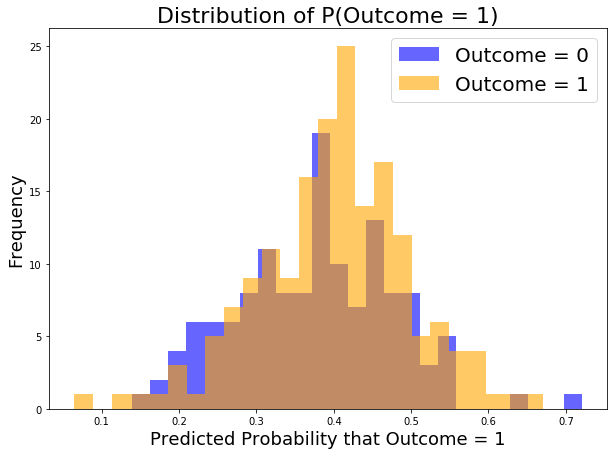

In [126]:
plotprob(snopes_pred)

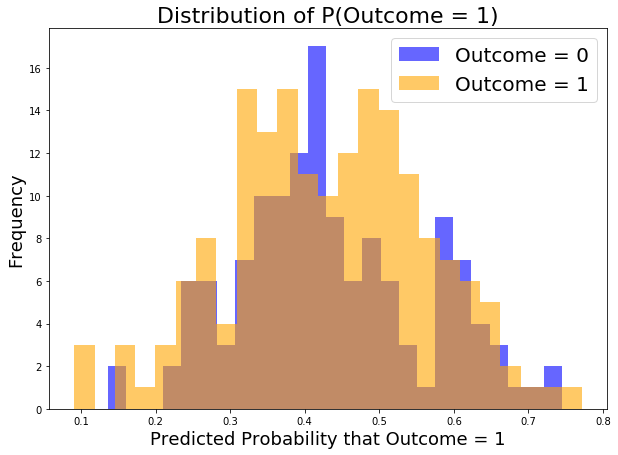

In [127]:
plotprob(snopes_pos_pred)

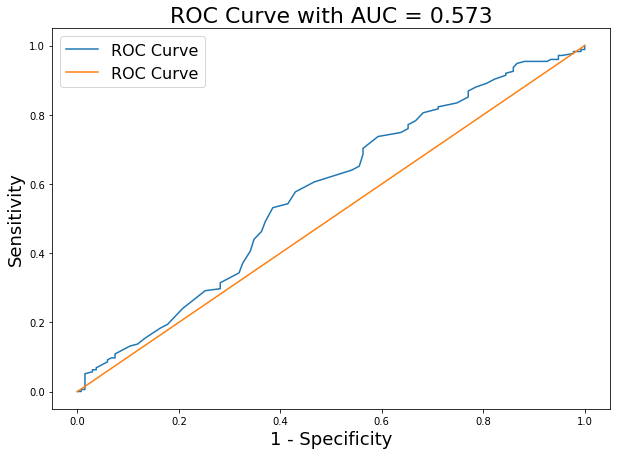

In [128]:
rocauccurve(snopes_pred)

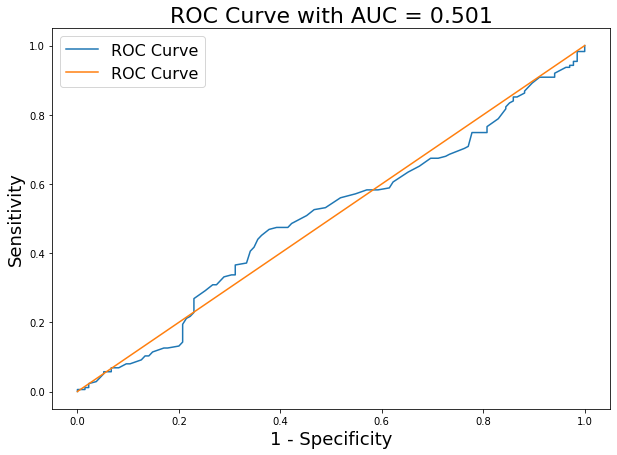

In [129]:
rocauccurve(snopes_pos_pred)

### Comments

Unlike what was hoped, the POS-only model performed much worse than that for the best model. Both models showed poor generalizability outside of the topics covered in the dataset. 

## Final Conclusion

As the size of the hand-labeled datasets generally number around the couple of thousand, and are on rather focused particular topics, models built on them are not general classifiers. A model such as this can help watchdogs focused on a particular topic; in this case American Politics, in greatly increasing the number of fake news articles classified when the source is unknown. 

Deep learning models were used and , including Self-Embedded layers with LSTM and BiDirectional LSTM, Word Vectors pretrained on Google News Dataset, and finally, BERT.

For a more generalized classifier, we move onto the Fake News Corpus, which labels news by domain. A classifier built on this would be more of a fake news site detector than a fake news classifier per se, but for most purposes should serve.